In [ ]:
import warnings
# Hide the pandas FutureWarnings that pybaseball triggers internally
warnings.filterwarnings("ignore", category=FutureWarning, module=r".*pybaseball.*")
# (Optional) if you still see any date parsing UserWarnings from pandas:
warnings.filterwarnings("ignore", category=UserWarning, message=r"Could not infer format.*")

# Milestone 2 — Data Exploration & Initial Preprocessing (SMALL SCALE, very much a wip)

This notebook fetches MLB data from `pybaseball`, assembles a game-level dataset for the 2023 season (we will expand), explores columns/distributions, and outlines preprocessing for a decision tree model.

**Links:**
- PyPI: https://pypi.org/project/pybaseball/
  
**Environment**: see `requirements.txt` in the repo root.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from pybaseball import team_batting, team_pitching, cache
cache.enable()
DATA_DIR = Path('../data/raw'); DATA_DIR.mkdir(parents=True, exist_ok=True)
SEASONS = [2023]
TEAMS = ['ARI','ATL','BAL','BOS','CHC','CHW','CIN','CLE','COL','DET','HOU','KCR','LAA','LAD','MIA','MIL','MIN','NYM','NYY','OAK','PHI','PIT','SDP','SEA','SFG','STL','TBR','TEX','TOR','WSN']
print(f"Seasons: {SEASONS} | Teams: {len(TEAMS)}")


Seasons: [2023] | Teams: 30


## Build a game-level table (home-team perspective)
We pull each team's schedule/results and keep only home games only so each game appears once. The target is `home_win`.


In [ ]:
import pandas as pd
import numpy as np
import re
import time
import requests


TEAM_LEAGUE = { # league mapping
    'ARI':'NL','ATL':'NL','BAL':'AL','BOS':'AL','CHC':'NL','CHW':'AL','CIN':'NL','CLE':'AL',
    'COL':'NL','DET':'AL','HOU':'AL','KCR':'AL','LAA':'AL','LAD':'NL','MIA':'NL','MIL':'NL',
    'MIN':'AL','NYM':'NL','NYY':'AL','OAK':'AL','PHI':'NL','PIT':'NL','SDP':'NL','SEA':'AL',
    'SFG':'NL','STL':'NL','TBR':'AL','TEX':'AL','TOR':'AL','WSN':'NL'
}

ALT = {'CHW':'CWS','WSN':'WAS','SFG':'SFN','TBR':'TBA','KCR':'KCA','LAA':'ANA','MIA':'FLO'}

STATS_ABBR = { 'ARI':'ARI','ATL':'ATL','BAL':'BAL','BOS':'BOS','CHC':'CHC','CHW':'CWS','CIN':'CIN','CLE':'CLE', 'COL':'COL','DET':'DET','HOU':'HOU','KCR':'KC','LAA':'LAA','LAD':'LAD','MIA':'MIA','MIL':'MIL', 'MIN':'MIN','NYM':'NYM','NYY':'NYY','OAK':'OAK','PHI':'PHI','PIT':'PIT','SDP':'SD','SEA':'SEA', 'SFG':'SF','STL':'STL','TBR':'TB','TEX':'TEX','TOR':'TOR','WSN':'WSH' }
INVERSE_STATS_ABBR = {v: k for k, v in STATS_ABBR.items()}  

STATIC_ABBR_TO_ID = {
    'ARI':109, 'ATL':144, 'BAL':110, 'BOS':111, 'CHC':112, 'CWS':145, 'CIN':113, 'CLE':114,
    'COL':115, 'DET':116, 'HOU':117, 'KC':118, 'LAA':108, 'LAD':119, 'MIA':146, 'MIL':158,
    'MIN':142, 'NYM':121, 'NYY':147, 'OAK':133, 'PHI':143, 'PIT':134, 'SD':135, 'SEA':136,
    'SF':137, 'STL':138, 'TB':139, 'TEX':140, 'TOR':141, 'WSH':120
}

def _parse_bbref_date(raw_series: pd.Series, season: int) -> pd.Series:
    s = raw_series.astype(str)
    return_str = s.copy()
    s = s.str.replace(r"\(.*?\)", "", regex=True)
    s = s.str.replace(r"^[A-Za-z]{3,9},\s*", "", regex=True)
    s = s.str.strip() + f" {season}"
    dt = pd.to_datetime(s, format="%b %d %Y", errors="coerce")
    m = dt.isna()
    if m.any():
        dt2 = pd.to_datetime(s[m], format="%B %d %Y", errors="coerce")
        dt.loc[m] = dt2
    return dt

def _has_doubleheader(raw_date: pd.Series, gm_num: pd.Series | None = None) -> pd.Series:
    has_paren = raw_date.astype(str).str.contains(r"\((?:1|2)\)", regex=True)  # non-capturing group
    if gm_num is not None:
        try:
            gm_num_int = pd.to_numeric(gm_num, errors="coerce")
            return has_paren | (gm_num_int.fillna(0) > 1)
        except Exception:
            pass
    return has_paren


_ID_BY_ABBR = {}
_ABBR_BY_ID = {}

def _init_team_maps(season: int):
    
    global _ID_BY_ABBR, _ABBR_BY_ID
    if _ID_BY_ABBR:
        return

    api_abbr_to_id = {}
    # Try season-scoped call, then general call
    for params in ({"sportId": 1, "season": season}, {"sportId": 1}):
        try:
            r = requests.get("https://statsapi.mlb.com/api/v1/teams", params=params, timeout=30)
            r.raise_for_status()
            teams = r.json().get("teams", [])
            api_abbr_to_id = {t.get("abbreviation"): t.get("id") for t in teams
                              if t.get("abbreviation") and t.get("id")}
            if api_abbr_to_id:
                break
        except Exception:
            continue

    # Merge with static fallback so ALL 30 are present
    merged = dict(STATIC_ABBR_TO_ID)
    merged.update(api_abbr_to_id)  # live API wins if present

    _ABBR_BY_ID = {tid: abbr for abbr, tid in merged.items()}  # reverse map

    # Map YOUR codes -> Stats abbr -> id
    _ID_BY_ABBR = {mine: merged[api] for mine, api in STATS_ABBR.items()}


def _fetch_sched(season, team, tries=1, backoff=0.0):
   
    _init_team_maps(season)
    tid = _ID_BY_ABBR.get(team)
    if tid is None:
        raise KeyError(team)

    r = requests.get(
        "https://statsapi.mlb.com/api/v1/schedule",
        params={"sportId": 1, "teamId": tid, "startDate": f"03/01/{season}", "endDate": f"12/31/{season}", "gameType": "R"},
        timeout=60
    )
    r.raise_for_status()
    data = r.json()

    games = []
    for d in data.get("dates", []):
        for g in d.get("games", []):
            tm = g.get("teams", {})
            home, away = tm.get("home", {}), tm.get("away", {})
            games.append({
                "game_pk": g.get("gamePk"),
                "game_date": d.get("date"),
                "status_code": (g.get("status") or {}).get("statusCode", ""),
                "home_id": (home.get("team") or {}).get("id"),
                "away_id": (away.get("team") or {}).get("id"),
                "home_score": home.get("score"),
                "away_score": away.get("score"),
                "game_num": g.get("gameNumber"),
                "day_night": g.get("dayNight"),
            })

    df = pd.DataFrame(games)
    if df.empty:
        return df

    is_home = df["home_id"].eq(tid)

    # Opponent abbr via ID -> abbr map (object dtype)
    opp = df["away_id"].map(_ABBR_BY_ID)
    opp_alt = df["home_id"].map(_ABBR_BY_ID)
    opp = opp.where(is_home, opp_alt).astype(object)

    idx = df.index
    out = pd.DataFrame(index=idx)
    out["Tm"]         = pd.Series(team, index=idx, dtype=object)
    out["Opp"]        = opp
    out["Home_Away"]  = pd.Series(np.where(is_home, "", "@"), index=idx, dtype=object)
    out["Date"]       = pd.to_datetime(df["game_date"], errors="coerce").dt.strftime("%b %d")
    out["R"]          = pd.to_numeric(df["home_score"].where(is_home, df["away_score"]), errors="coerce")
    out["RA"]         = pd.to_numeric(df["away_score"].where(is_home, df["home_score"]), errors="coerce")
    out["Inn"]        = pd.Series(np.nan, index=idx)
    out["Gm#"]        = pd.to_numeric(df["game_num"], errors="coerce")
    out["D/N"]        = df["day_night"].astype(object)
    out["Time"]       = pd.Series(np.nan, index=idx)
    out["Attendance"] = pd.Series(np.nan, index=idx)
    out["game_id"]    = df["game_pk"]

    # Final/Game Over via status codes (F, O)
    finished = df["home_score"].notna() & df["away_score"].notna()
    w = pd.Series(np.nan, index=out.index, dtype=object)
    w.loc[finished & (out["R"] > out["RA"])] = "W"
    w.loc[finished & (out["R"] < out["RA"])] = "L"
    out["W/L"] = w

    cols = ["Tm","Opp","Date","R","RA","Inn","Gm#","D/N","Time","Attendance","W/L","Home_Away","game_id"]
    return out[cols]

  



def _parse_time_to_minutes(time_col: pd.Series) -> pd.Series:
    def to_min(x):
        if pd.isna(x):
            return np.nan
        m = re.match(r"^\s*(\d+):(\d{2})\s*$", str(x))
        if m:
            h, mm = int(m.group(1)), int(m.group(2))
            return 60*h + mm
        return np.nan
    return time_col.apply(to_min)

def _parse_day_night(x):
    x = str(x).strip().upper()
    if x in ("D","DAY"):
        return "Day"
    if x in ("N","NIGHT"):
        return "Night"
    return np.nan

def _to_int_safe(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s.lower() == "unknown" or s == "":
        return np.nan
    s = s.replace(",", "")
    return pd.to_numeric(s, errors="coerce")

def load_games_for_season(season: int) -> pd.DataFrame:
    rows = []
    for tm in TEAMS:
        try:
            df = _fetch_sched(season, tm)
        except Exception as e:
            print(f"[SKIP] {tm} {season}: {e}")
            continue
        if df is None or df.empty:
            print(f"[SKIP] {tm} {season}: empty schedule")
            continue
        
        req = {"Date", "R", "RA"}
        if not req.issubset(df.columns):
            print(f"[SKIP] {tm} {season}: missing {req - set(df.columns)}")
            continue

        raw_date = df["Date"].astype(str)

        ha_col = "Home_Away" if "Home_Away" in df.columns else ("H/A" if "H/A" in df.columns else None)
        
        df = df[~df[ha_col].astype(str).str.contains("@")]  
        df = df[df["R"].notna() & df["RA"].notna()].copy()

        df["date"] = _parse_bbref_date(df["Date"], season)

        df = df.rename(columns={"Tm":"home_team","Opp":"away_team","R":"home_runs","RA":"away_runs"})
        df["away_team"] = df["away_team"].map(INVERSE_STATS_ABBR).fillna(df["away_team"])
        
        df["home_win"] = (df["home_runs"] > df["away_runs"]).astype(int)

        # season
        df["season"] = season

        # game number (Gm#) and doubleheader flag
        gm_num = df["Gm#"] if "Gm#" in df.columns else None
        df["game_number"] = pd.to_numeric(gm_num, errors="coerce") if gm_num is not None else np.nan
        df["is_doubleheader"] = _has_doubleheader(raw_date.loc[df.index], gm_num.loc[df.index] if gm_num is not None else None).astype(int)

        # day/night
        dn = df["D/N"] if "D/N" in df.columns else None
        df["day_night"] = dn.map(_parse_day_night) if dn is not None else np.nan

        # attendance (int)
        att = df["Attendance"] if "Attendance" in df.columns else None
        df["attendance"] = att.map(_to_int_safe) if att is not None else np.nan

        # game time in minutes
        time_col = df["Time"] if "Time" in df.columns else None
        df["game_time_minutes"] = _parse_time_to_minutes(time_col) if time_col is not None else np.nan

        # innings / extra innings flag
        inn = df["Inn"] if "Inn" in df.columns else None
        df["innings"] = pd.to_numeric(inn, errors="coerce") if inn is not None else np.nan
        df["is_extra_innings"] = (
            np.where(df["innings"].notna(), (df["innings"] > 9).astype(int), np.nan)
            if "innings" in df.columns else np.nan
        )

        # simple run differential (home perspective)
        df["run_diff"] = df["home_runs"] - df["away_runs"]

        # calendar features
        df["month"] = df["date"].dt.month
        df["weekday"] = df["date"].dt.day_name()

        # league & interleague
        df["home_league"] = df["home_team"].map(TEAM_LEAGUE)
        df["away_league"] = df["away_team"].map(TEAM_LEAGUE)
        df["is_interleague"] = (df["home_league"] != df["away_league"]).astype(int)

        keep_cols = [
        "season","date","home_team","away_team",
        "home_runs","away_runs","home_win","run_diff",
        "game_number","is_doubleheader","day_night","attendance","game_time_minutes",
        "innings","is_extra_innings","month","weekday","home_league","away_league","is_interleague",
        "game_id"  # NEW
        ]
        cols = [c for c in keep_cols if c in df.columns]
        rows.append(df[cols])
    if not rows:
        return pd.DataFrame(columns=[
            "season","date","home_team","away_team",
            "home_runs","away_runs","home_win","run_diff",
            "game_number","is_doubleheader","day_night","attendance","game_time_minutes",
            "innings","is_extra_innings","month","weekday","home_league","away_league","is_interleague"
        ])

    out = pd.concat(rows, ignore_index=True)
    out = out[out["date"].notna()]

    # Prefer unique MLB game id for dedup
    if "game_id" in out.columns:
        out = out.drop_duplicates(subset=["game_id"])
    else:
        out = out.drop_duplicates(subset=["date","home_team","away_team","home_runs","away_runs"])

    return out.sort_values("date").reset_index(drop=True)

games = pd.concat([load_games_for_season(y) for y in SEASONS], ignore_index=True)
print(games.shape)
games.head()





(2430, 21)


,season,date,home_team,away_team,home_runs,away_runs,home_win,run_diff,game_number,is_doubleheader,...,attendance,game_time_minutes,innings,is_extra_innings,month,weekday,home_league,away_league,is_interleague,game_id
0,2023,2023-03-30,KCR,MIN,0.0,2.0,0,-2.0,1,0,...,NaN,NaN,NaN,NaN,3,Thursday,AL,AL,0,718775
1,2023,2023-03-30,NYY,SFG,5.0,0.0,1,5.0,1,0,...,NaN,NaN,NaN,NaN,3,Thursday,AL,NL,1,718781
2,2023,2023-03-30,CHC,MIL,4.0,0.0,1,4.0,1,0,...,NaN,NaN,NaN,NaN,3,Thursday,NL,NL,0,718777
3,2023,2023-03-30,WSN,ATL,2.0,7.0,0,-5.0,1,0,...,NaN,NaN,NaN,NaN,3,Thursday,NL,NL,0,718780
4,2023,2023-03-30,SDP,COL,2.0,7.0,0,-5.0,1,0,...,NaN,NaN,NaN,NaN,3,Thursday,NL,NL,0,718778


### Summary: rows, columns, duplicates, missing values


In [ ]:
print('Rows:', len(games), ' Columns:', games.shape[1])
print('\nDtypes:')
print(games.dtypes)
print('\nMissing by column:')
print(games.isna().sum())
dupes = games.duplicated(subset=['date','home_team','away_team']).sum()
print(f"\nDuplicate (date, home, away) rows: {dupes}")


Rows: 2430  Columns: 21

Dtypes:
season                        int64
date                 datetime64[ns]
home_team                    object
away_team                    object
home_runs                   float64
away_runs                   float64
home_win                      int64
run_diff                    float64
game_number                   int64
is_doubleheader               int64
day_night                    object
attendance                  float64
game_time_minutes           float64
innings                     float64
is_extra_innings            float64
month                         int32
weekday                      object
home_league                  object
away_league                  object
is_interleague                int64
game_id                       int64
dtype: object

Missing by column:
season                  0
date                    0
home_team               0
away_team               0
home_runs               0
away_runs               0
home_win             

## Merge team-level season stats (batting & pitching)


In [ ]:
print(team_batting(2023).columns)

Index(['teamIDfg', 'Season', 'Team', 'Age', 'G', 'AB', 'PA', 'H', '1B', '2B',
       ...
       'maxEV', 'HardHit', 'HardHit%', 'Events', 'CStr%', 'CSW%', 'xBA',
       'xSLG', 'xwOBA', 'L-WAR'],
      dtype='object', length=319)


In [ ]:
ABBR_TO_NAME = { #mapping names to abbrvs, just in case
    'ARI':'Arizona Diamondbacks','ATL':'Atlanta Braves','BAL':'Baltimore Orioles','BOS':'Boston Red Sox',
    'CHC':'Chicago Cubs','CHW':'Chicago White Sox','CIN':'Cincinnati Reds','CLE':'Cleveland Guardians',
    'COL':'Colorado Rockies','DET':'Detroit Tigers','HOU':'Houston Astros','KCR':'Kansas City Royals',
    'LAA':'Los Angeles Angels','LAD':'Los Angeles Dodgers','MIA':'Miami Marlins','MIL':'Milwaukee Brewers',
    'MIN':'Minnesota Twins','NYM':'New York Mets','NYY':'New York Yankees','OAK':'Oakland Athletics',
    'PHI':'Philadelphia Phillies','PIT':'Pittsburgh Pirates','SDP':'San Diego Padres','SEA':'Seattle Mariners',
    'SFG':'San Francisco Giants','STL':'St. Louis Cardinals','TBR':'Tampa Bay Rays','TEX':'Texas Rangers',
    'TOR':'Toronto Blue Jays','WSN':'Washington Nationals'
}
NAME_TO_ABBR = {v: k for k, v in ABBR_TO_NAME.items()}
ALIASES = {'WSH':'WSN','TB':'TBR','SD':'SDP','KC':'KCR','CWS':'CHW','SF':'SFG','AZ':'ARI'}

def normalize_team_key(df: pd.DataFrame, team_col: str = "Team") -> pd.Series:
    vals = df[team_col].astype(str).str.strip().str.replace(r"\s*\(.*\)$", "", regex=True)
    known = set(ABBR_TO_NAME.keys())
    if vals.isin(known).mean() >= 0.9:
        return vals.replace(ALIASES)
    return vals.map(NAME_TO_ABBR)

def team_batting_minimal(season: int) -> pd.DataFrame:
    tb = team_batting(season).copy()
    tb.columns = tb.columns.str.strip()
    if "BA" not in tb.columns and "AVG" in tb.columns:
        tb = tb.rename(columns={"AVG": "BA"})
    if "OPS" not in tb.columns and {"OBP","SLG"}.issubset(tb.columns):
        tb["OPS"] = tb["OBP"] + tb["SLG"]
    keep = [c for c in ["Team","BA","OBP","SLG","OPS","R"] if c in tb.columns]
    tb = tb[keep].rename(columns={"R":"season_runs"})
    tb["team"] = normalize_team_key(tb, "Team")
    return tb[["team","BA","OBP","SLG","OPS","season_runs"]]

def team_pitching_minimal(season: int) -> pd.DataFrame:
    tp = team_pitching(season).copy()
    tp.columns = tp.columns.str.strip()
    keep = [c for c in ["Team","ERA","WHIP"] if c in tp.columns]
    tp = tp[keep]
    tp["team"] = normalize_team_key(tp, "Team")
    return tp[["team","ERA","WHIP"]]

bat = pd.concat([team_batting_minimal(y) for y in SEASONS], ignore_index=True)
pit = pd.concat([team_pitching_minimal(y) for y in SEASONS], ignore_index=True)
team_stats = bat.merge(pit, on="team", how="inner")

g = games.merge(team_stats.add_prefix("home_"), left_on="home_team", right_on="home_team", how="left")
g = g.merge(team_stats.add_prefix("away_"), left_on="away_team", right_on="away_team", how="left")

print(g.shape)
print("home_ NaN rate:", g["home_BA"].isna().mean())
print("away_ NaN rate:", g["away_BA"].isna().mean())
g.head()


(2430, 35)
home_ NaN rate: 0.0
away_ NaN rate: 0.03333333333333333


,season,date,home_team,away_team,home_runs,away_runs,home_win,run_diff,game_number,is_doubleheader,...,home_season_runs,home_ERA,home_WHIP,away_BA,away_OBP,away_SLG,away_OPS,away_season_runs,away_ERA,away_WHIP
0,2023,2023-03-30,KCR,MIN,0.0,2.0,0,-2.0,1,0,...,676,5.17,1.41,0.243,0.326,0.428,0.753,778.0,3.87,1.20
1,2023,2023-03-30,NYY,SFG,5.0,0.0,1,5.0,1,0,...,673,3.97,1.24,0.235,0.312,0.383,0.695,674.0,4.02,1.25
2,2023,2023-03-30,CHC,MIL,4.0,0.0,1,4.0,1,0,...,819,4.09,1.28,0.240,0.319,0.385,0.704,728.0,3.73,1.19
3,2023,2023-03-30,WSN,ATL,2.0,7.0,0,-5.0,1,0,...,700,5.02,1.47,0.276,0.344,0.501,0.845,947.0,4.14,1.30
4,2023,2023-03-30,SDP,COL,2.0,7.0,0,-5.0,1,0,...,752,3.73,1.27,0.249,0.310,0.405,0.715,721.0,5.68,1.55


## Recent form: rolling last-10 win percentage (no leakage)


In [ ]:
def rolling_win_pct(df_sched: pd.DataFrame, team_col='home_team') -> pd.DataFrame:
    if df_sched is None or df_sched.empty:
        return df_sched.assign(roll10_win_pct=np.nan)
    req = {'date', team_col, 'home_win'}
    missing = req - set(df_sched.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    out = []

    for tm, sub in df_sched.sort_values('date').groupby(team_col, sort=False, dropna=False):
        sub = sub.sort_values('date').copy()
        sub['roll10_win_pct'] = (
            sub['home_win'].rolling(10, min_periods=1).mean().shift(1)  # no leakage
        )
        out.append(sub)
    return pd.concat(out, ignore_index=True)


## Quick EDA


Home win rate: 0.521


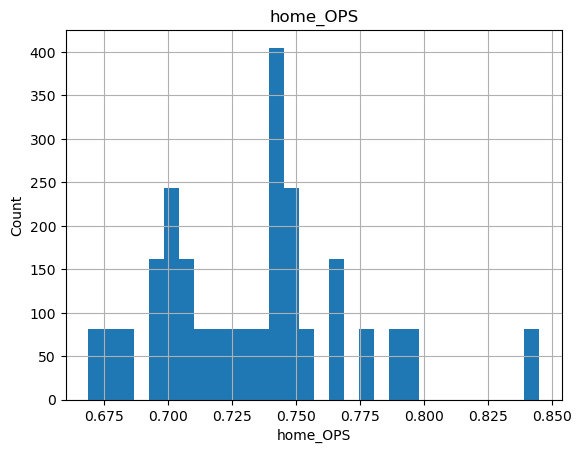

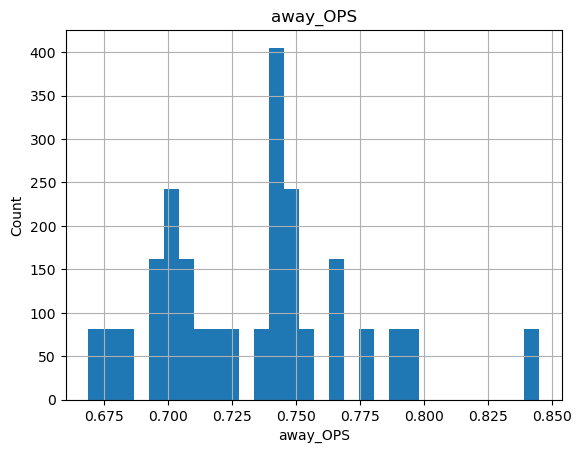

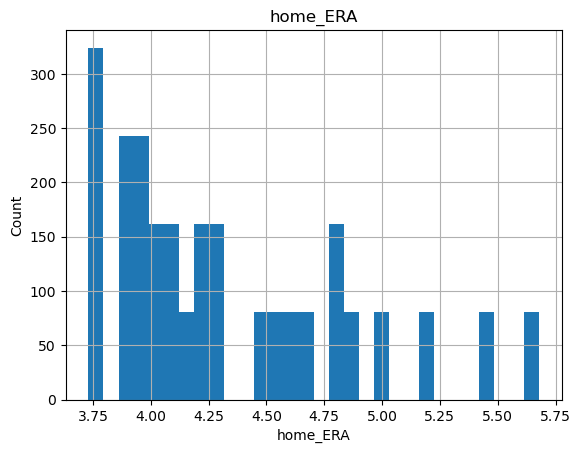

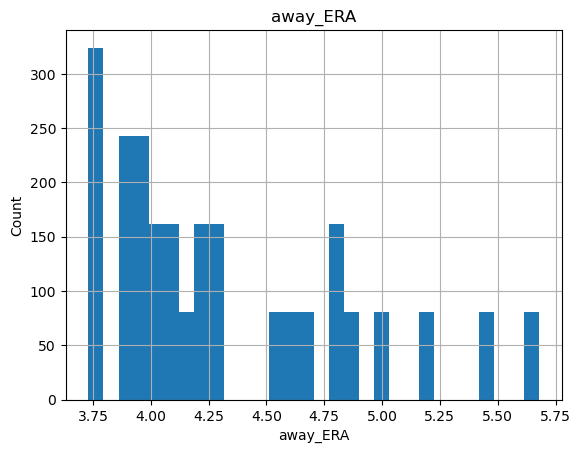

In [15]:
FIG_DIR = Path("../figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)

home_rate = g['home_win'].mean(); print(f"Home win rate: {home_rate:.3f}")
for col in ['home_OPS','away_OPS','home_ERA','away_ERA','roll10_win_pct']:
    if col in g.columns:
        plt.figure(); g[col].dropna().hist(bins=30)
        plt.title(col); plt.xlabel(col); plt.ylabel('Count')

        plt.savefig(FIG_DIR / f"{col}_hist.png", dpi=200, bbox_inches="tight")
        plt.show()


home_OPS: Distribution of home team OPS; most games fall in the .72–.76 range with a light right tail.

away_OPS: Away team OPS distribution closely mirrors home OPS; any small right shift would indicate a minor home hitting boost.

home_ERA: Home team ERA is concentrated around ~3.8–4.3 (lower is better), with a right tail toward higher ERAs.

away_ERA: Away team ERA has a similar shape; a slight right shift would imply marginally worse pitching on the road.

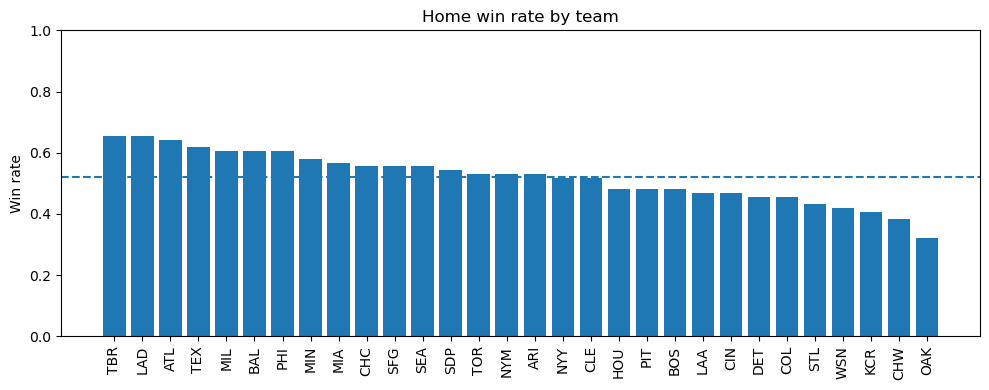

Overall home-field win rate: 0.521


In [16]:
g = g.copy()
g["home_win"] = pd.to_numeric(g["home_win"], errors="coerce")
g = g.dropna(subset=["home_win"])

team_win = (
    g.groupby("home_team", dropna=False)["home_win"]
      .mean()
      .sort_values(ascending=False)
)

if team_win.empty:
    raise ValueError("team_win is empty (no rows after filtering).")


overall = g["home_win"].mean()
n_per_team = (
    g.groupby("home_team", dropna=False)["home_win"].size()
     .reindex(team_win.index).astype(int)
)


plt.figure(figsize=(10,4))
plt.bar(team_win.index.astype(str), team_win.values)
plt.axhline(overall, linestyle="--")  
plt.title("Home win rate by team")
plt.ylabel("Win rate")
plt.xticks(rotation=90)
plt.ylim(0, 1)



plt.tight_layout()

plt.savefig(FIG_DIR / "bar_home_win_rate_by_team_hist.png", dpi=200, bbox_inches="tight")

plt.show()

print(f"Overall home-field win rate: {overall:.3f}")



Each bar is a team’s home win rate; the dashed line is the league average 0.521. Teams above the line (e.g., TBR, LAD, ATL) outperformed; below (e.g., OAK, CHW, KCR) underperformed. Average > 0.5 confirms home-field advantage.

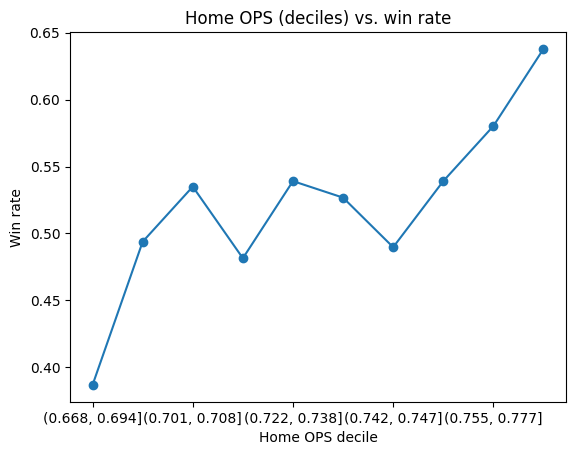

In [ ]:
if 'home_OPS' in g.columns:
    mask = g['home_OPS'].notna()
    bins = pd.qcut(g['home_OPS'].dropna(), q=10, duplicates='drop')
    win_by_ops = g.loc[mask].groupby(bins, observed=True)['home_win'].mean()
    plt.figure(); win_by_ops.plot(marker='o')
    plt.title('Home OPS (deciles) vs. win rate')
    plt.xlabel('Home OPS decile'); plt.ylabel('Win rate'); plt.show()


Win rate rises with home OPS. Bottom decile ≈ 0.39, top decile ≈ 0.64, indicating a strong positive link between better offensive output and winning at home.

## Rolling last-10 win % distribution

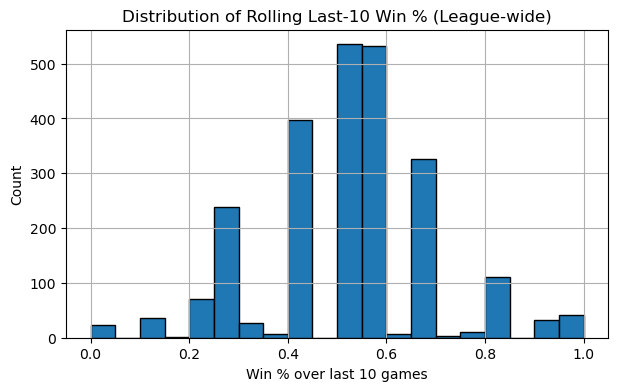

In [17]:
g_roll = rolling_win_pct(g, team_col="home_team")

plt.figure(figsize=(7,4))
g_roll["roll10_win_pct"].hist(bins=20, edgecolor="black")
plt.title("Distribution of Rolling Last-10 Win % (League-wide)")
plt.xlabel("Win % over last 10 games")
plt.ylabel("Count")

plt.savefig(FIG_DIR / "roll10_winpct_hist.png", dpi=200, bbox_inches="tight")
plt.show()

The Distribution of teams' rolling last-10 win percentages histogram shows how often teams’ win rates over their last 10 games fall into different percentage ranges. Most values cluster around 40–60% with fewer streaks near 0% or 100%.

## CSV snapshot (check size -> we need 10-100 GB total)
- with current specs, will need 20 seasons so expand attributes to include all columns, with all columns we'll need ~5 years; should do 2016–2023 (no 2020 since pandemic), test 2024


In [11]:
out_path = Path('../data/raw') / 'games_2023.csv'
g.to_csv(out_path, index=False); out_path


PosixPath('../data/raw/games_2023.csv')

## Notes for Milestone 3
- We're training a DecisionTreeClassifier with stratified/time-aware splits
- the feature set will include the season-level and rolling features created above (no leakage)
- outputs: report accuracy, precision, recall, etc, and feature importances
